# PHAS0031:Computational Physics: Week 7: Assessment
## Joshua Giblin-Burnham(SN.:19052055)

### Introduction: 
 We will be we will be producing a molecular dynamics simulation of the Lennard-Jones model of Ne, the Lennnard-Jones potential is given by:
 
 $$V(r)=4\epsilon\left[\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^6\right]$$
 
 We can then get the force, given by its derivative:
 
 $$\begin{matrix}\mathbf{F}_i(\mathbf{r}_{ij})&=&-\mathrm{\nabla}_jV(r_{ij})=-24\epsilon\widehat{\mathbf{r}_{\mathbf{ij}}}\left[2\frac{\sigma^{12}}{r_{ij}^{13}}-\frac{\sigma^6}{r_{ij}^7}\right]\\&=&24\epsilon\mathbf{r}_{ij}\left[\frac{\sigma^6}{r_{ij}^8}-2\frac{\sigma^{12}}{r_{ij}^{14}}\right]=-\mathbf{F}_j(\mathbf{r}_{ij})\\\end{matrix}$$

In [1]:
# Appropriate imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Section 1: Main task:
### Set up the force function
First we write a function to calculate the Lennard-Jones energy and force. For the force we will produce an array of the 3-dimensionall force for all particles, ie an $Ni \times 3$ dimensional array, where the $Ni$ is number of particles and 3 represents the three dimensions of space. The energy is a scalar value as the sum of potential from particle pairs. Giving these sums in tensor/ array form as they will be implimented, we have:

$$V_t(r_t)=4\epsilon\sum_{i=1}^{N_i}\sum_{j=i+1}^{N_i}\left[\left(\frac{\sigma}{|r_{ij}|}\right)^{12}-\left(\frac{\sigma}{|r_{ij}|}\right)^6\right]$$

$$V[t]=4\epsilon\sum_{i=1}^{N_i}\sum_{j=i+1}^{N_i}\left[\left(\frac{\sigma}{(r[j]-r[i])}\right)^{12}-\left(\frac{\sigma}{(r[j]-r[i])}\right)^6\right]$$

where:
- $V_t$ is the potential array element $t$, which gives potential at time $t\cdot dt$, thus total array $V$ has dimension $Nt$ (notation, $V=V_t$)

- $r_t$ is the position array element $t$, giving the position array of all particles at time $t\cdot dt$, thus r_t has dimension $ Ni \times 3 $ and notation $r_t= r_{i,xyz}$. (As total $r$ array has dimensions $ Nt \times Ni \times 3 $ and notation $r = r_{t,i,xyz}$) 

- $r_{ij}$ is the vector between the $i^{th}$ and $j^{th}$ particle positon/ subtraction of the $i^{th}$ and $j^{th}$ component of the  $r_t$ array; given as $ r_{ij}= r_j-r_i = r_{ij_{xyz}} $ thus has dimension $1 \times 3$ . So $|r_{ij}|$ is the distance between $r_t,i$ and $r_t,j$ particles and thus a scalar

(Note: $t$ is an integer $ 0 \leq t \leq N_t $)

And, 
$$\mathbf{F}_{t,i}({r}_{t}) = 
\left[\sum_{j=i+1}^{N_i} \left[24\epsilon\bar{r}_{ij}\left(\frac{\sigma^6}{|r_{ij}|^8}-2\frac{\sigma^{12}}{|r_{ij}|^{14}}\right)\right] \quad \right]_t
=-\mathbf{F}_{t,j}(\bar{r}_{ij})$$

$$ F[t,i] = \sum_{j=i+1}^{N_i} \left[24\epsilon(r[i]-r[j])\left(\frac{\sigma^6}{(r[i]-r[j])^8}-2\frac{\sigma^{12}}{(r[i]-r[j])^{14}}\right)\right] = - F[t,j]$$

where:
- $F_{t,i}$ is the Force array element $[t,i]$, which gives sum of forces at time $t\cdot dt$ on particle i, thus total array $F$ has dimension $Nt \times Ni \times 3$ (notation, $F=F_{t,i,xyz}$)

- $r_t$ is the position array element $t$, giving the position array of all particles at time $t\cdot dt$, thus r_t has dimension $ Ni \times 3 $ and notation $r_t= r_{i,xyz}$. (As total $r$ array has dimensions $ Nt \times Ni \times 3 $ and notation $r = r_{t,i,xyz}$) 

- $r_{ij}$ is the vector between the $i^{th}$ and $j^{th}$ particle positon/ subtraction of the $i^{th}$ and $j^{th}$ component of the  $r_t$ array; given as $ r_{ij}= r_j-r_i = r_{ij_{xyz}} $ thus has dimension $1 \times 3$ . So $|r_{ij}|$ is the distance between $r_t,i$ and $r_t,j$ particles and thus a scalar

(Note: $t$ is an integer $ 0 \leq t \leq N_t $)

In [2]:
def F(r, Ni, epsilon, sigma,L):
    '''Evaluate the Force and Potential due to Lennard-Jones potential
    Inputs:     
    r            Position array at time step, t
    Ni           No. of particles
    Epsilon      Constant epsilon value
    Sigma        Constant sigma value
    
    Output:
    F            Force array at time step, t
    V            Potential value at time step, t
    '''
    
    # Initialise Force and Potential
    F = np.zeros([Ni,3])
    V = 0.0
    
    # Calculates sigma to powers before loop
    sigma6 = sigma**6
    sigma12 = sigma6*sigma6
    
    # Loop over  particle pairs
    for i in range(Ni):
        for j in range(i+1,Ni):
            rij  = r[j] - r[i]
            rij -= L*np.rint(rij/L)
            # Calculates distance vector, ensures shorter distanced is used 
            
            dr   = np.sum(rij*rij)
            dri  = 1/dr
            dri6 = dri*dri*dri
            # Calculate inverse powers of distance magnitude
            
            Fij  = 24*epsilon*rij*( dri * dri6 * ( sigma6 - 2*sigma12 * dri6 ) )  
            # Calculates Force
            
            F[i] += Fij
            F[j] -= Fij
            # Adds to Force array
            
            V += 4*epsilon*( dri6 * ( sigma12*dri6 - sigma6 ) )
            # Calculates Potential sum
            
    return F,V

### Set up the lattice and the simulation parameters

We set up a lattice of $64 Ne$ atoms on cubic grid points, using a box length of $1.1\times2^{1/6}\sigma\times N_{cells}$ . We set the number of times steps, $N_{t}$, to 1000, the number of particles $N_i$, timestep $dt$ and constants $\epsilon,\sigma,k_B,m$. Then we plot the system in 3D with a scatter plot..Then plot the system in 3D with a scatter plot.

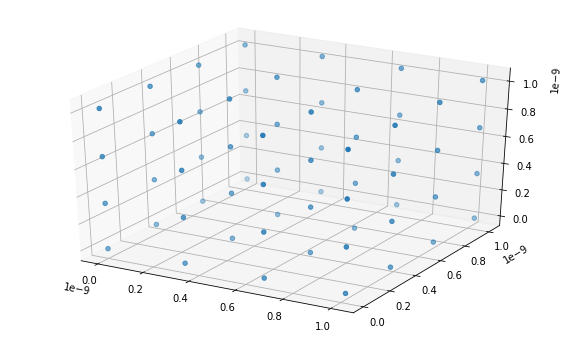

In [3]:
# Initialisation of variables 

kb      = 1.38e-23 
epsilon = 36*kb    
sigma   = 0.275e-9
m       = 20.2*1.673e-27 

Nt = 10000
dt = 1e-15

Ncell = 4
Ni    = Ncell**3                  
L     = 1.1*(2**(1/6))*sigma*Ncell

r  = np.zeros([Nt,Ni,3])
v  = np.zeros([Nt,Ni,3])

part_no = 0
for i in range(Ncell):
    for j in range(Ncell):
        for k in range(Ncell):
            r[0, part_no] = (L/Ncell) * np.array([i, j, k])
            part_no += 1
            
fig1 = plt.figure(figsize=(10,6))
ax1  = fig1.add_subplot(111, projection='3d')
ax1.scatter(r[0,:,0],r[0,:,1],r[0,:,2])
plt.show()

### Initialise velocities
We initialise the velocities randomly and normalise to have the correct temperture based on the equation below:

$$mC^2\Sigma_iv_i^2=3N_{part}k_BT$$

And we calculate temperature based of the the following equation:

$$\frac{1}{2}mv^2=\frac{3}{2}k_BT$$

In [4]:
# Set initial temperature
T0   = 50

# Initialise velocities the initial distribution can have an arbitrary scaling, rescales the velocities
v[0] = np.random.normal(size=(Ni, 3))
C    = np.sqrt((3*Ni*kb*T0)/(m*np.sum(v[0]*v[0])))
v[0]*= C

# Set up energy and temperature arrays
Pe = np.zeros(Nt)
T  = np.zeros(Nt)
T[0]= m*np.sum(v[0]*v[0])/(3*kb*Ni)

# Past function and calculates acceleration
F0, Pe[0] = F(r[0], Ni, epsilon, sigma, L)
a0        = F0/m

# Mean squared displacement array
D = np.zeros(Nt-1)

print("Potential energy and temperature are ", Pe[0] ,"J ", T[0],"K")

Potential energy and temperature are  -1.123419416250599e-19 J  50.000000000000014 K


### Run simulation
Now we run the simulation for 10,000 steps with a timestep of ${10}^{-15}s$ (this take several minutes), and store the particle positions, temperature, least the mean square displacement and velocity at each step. We ensure periodic boundary conditions. The mean squared displacement is defined as:

$$D(t)=\frac{1}{N}\sum_{i=1}^{N}\left(\mathbf{r}_i(t)-\mathbf{r}_i(0)\right)^2$$

(this give array with size $1 \times (N_t-1)$, as we calculate from $t=dt$ onwards)

In [5]:
for t in range(1,Nt):
    
    r[t] = r[t-1] + dt*v[t-1] + (a0/2)*dt**2
    r[t] = r[t] % L
    # Periodic boundaries
    
    Fi, Pe[t] = F(r[t], Ni, epsilon, sigma, L)
    a1 = Fi/m

    v[t] = v[t-1] + dt*(a0 + a1)/2
    T[t] = m*np.sum(v[t]*v[t])/(3*kb*Ni)
    
    a0 = a1
 
    # Calculate mean-squared displacement
    D[t-1] = np.sum( (r[t]-r[0])*(r[t]-r[0])  )
D /= Ni

### Plots from simulation

Plot the displacement against time. And plot D(t)/(6t) against time from 2ps onwards.

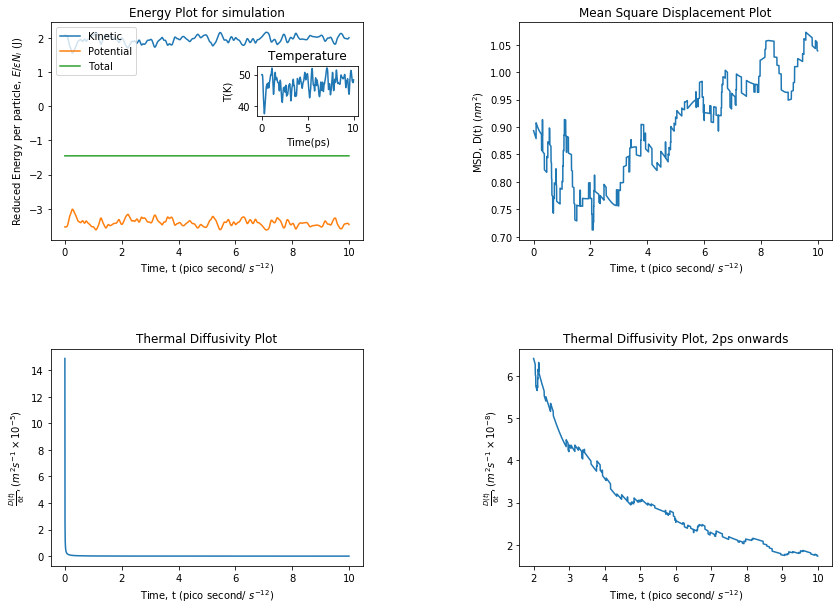

In [6]:
# Calculates Kinetic energy array
Ke  = 0.5*m*np.sum(v*v,axis=(1,2))
#Ke = (3/2)*kb*T #(alternative calculation)

# Time array and MSD/6t/ Thermal diffusivity
Tt  = dt*np.arange( 0, Nt)
D6t = D/(6*Tt[1:])

# Plots from simulation (arrays are multipled to power to plot as nano/pico units)
fig2, ax = plt.subplots(2, 2, figsize=(14,10))

# Energy plots to ensure simulation has run correctly( constant energy/ conservation )
ax[0,0].plot(Tt*1e12, Ke/(Ni*epsilon), label='Kinetic')
ax[0,0].plot(Tt*1e12, Pe/(Ni*epsilon), label='Potential')
ax[0,0].plot(Tt*1e12, (Pe+Ke)/(Ni*epsilon), label='Total')

ax[0,0].set_xlabel(r'Time, t (pico second/ $s^{-12}$)')
ax[0,0].set_ylabel(r'Reduced Energy per particle, $E/\epsilon N_i$ (J)')
ax[0,0].set_title('Energy Plot for simulation')
ax[0,0].legend(loc=2)

# Temperture small plot
ax2 = fig2.add_axes([0.33, 0.75, 0.1, 0.07])
ax2.set_xlabel('Time(ps)')
ax2.set_ylabel('T(K)')
ax2.plot(Tt*1e12, T, label='Temperature')
ax2.set_title('Temperature')

# Plot of reduce mean square distance
ax[0,1].plot(Tt[1:]*1e12,D*(1e9**2))
ax[0,1].set_xlabel(r'Time, t (pico second/ $s^{-12}$)')
ax[0,1].set_ylabel(r'MSD, D(t) $(nm^2)$')
ax[0,1].set_title('Mean Square Displacement Plot')

# Plot of reduce mean square distance divided by time, over all time
ax[1,0].plot(Tt[1:]*1e12, D6t*1e5)
ax[1,0].set_xlabel(r'Time, t (pico second/ $s^{-12}$)')
ax[1,0].set_ylabel(r'$\frac{D(t)}{6t}, (m^2s^{-1}\times 10^{-5}$)')
ax[1,0].set_title('Thermal Diffusivity Plot')

# Plot of reduce mean square distance divided by time, 2ps onwards
ax[1,1].plot(Tt[2001:]*1e12, D6t[2000:]*1e8)
ax[1,1].set_xlabel(r'Time, t (pico second/ $s^{-12}$)')
ax[1,1].set_ylabel(r'$\frac{D(t)}{6t}, (m^2s^{-1}\times 10^{-8}$)')
ax[1,1].set_title('Thermal Diffusivity Plot, 2ps onwards')

plt.subplots_adjust(wspace= 0.5, hspace= 0.5 ) 
plt.show()

#### Comment:
We see Energy plot is consistent with Physics as the total energy is conserved. We see on the plot of mean square displacement to movement is random but tending to increase, as would be expected; modulating this by time past then gives, $D$, the thermal diffusivity. We see this clear show exponential decay. Using the plot of $\frac{D(t)}{6t}$ past 2 ps we see that the exponential converages just below 2, giving the thermal diffusivity at  between 1.5-2, looking online we see the thermal diffusivity of neon at 58K is around $5\times10^{-8}$[1]. Looking at our temperature plot our simulation we see it oscilates around 40K-50K, thus our slightly lower thermal diffusivity agrees well with this.

### Calculate the Integral

Now calculate the following integral:
$$I(t)=\frac{1}{3N}\int_{0}^{t}\sum_{i=1}^{N}\mathbf{v}_i(t)\cdot\mathbf{v}_i(0)dt$$
with a simple numerical rectangle integration. The integral $I(t)$ is known as an auto-correlation function and is used widely in MD analysis. This finds the correlation in a signal with a delayed copy of itself as a function of the delay.

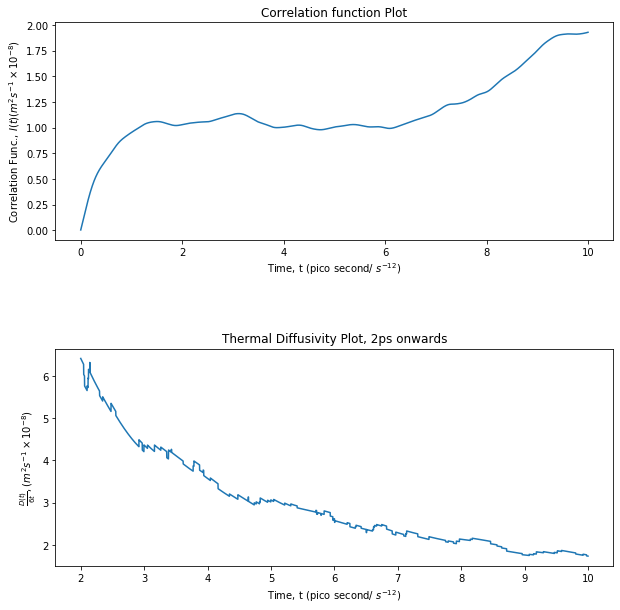

In [7]:
I = np.zeros(Nt)
I[0]= np.sum(v[0]*v[0])*dt
for t in range(1,Nt):
    I[t] = I[t-1] + np.sum(v[t]*v[0])*dt
I/= (3*Ni)

fig3, ax= plt.subplots(2, 1, figsize=(10,10))

# Plot of Integral
ax[0].plot(Tt*1e12, I*1e8)
ax[0].set_xlabel(r'Time, t (pico second/ $s^{-12}$)')
ax[0].set_ylabel(r'Correlation Func., $I(t) (m^2s^{-1}\times 10^{-8}$)')
ax[0].set_title('Correlation function Plot')

# Plot of reduce mean square distance divided by time, 2ps onwards
ax[1].plot(Tt[2001:]*1e12, D6t[2000:]*1e8)
ax[1].set_xlabel(r'Time, t (pico second/ $s^{-12}$)')
ax[1].set_ylabel(r'$\frac{D(t)}{6t}, (m^2s^{-1}\times 10^{-8}$)')
ax[1].set_title('Thermal Diffusivity Plot, 2ps onwards')

plt.subplots_adjust(hspace= 0.5 ) 
plt.show()

#### Comment 
Similarly, here we see with the correlation function converges in the range 1.5-2.0, however, the plot resembles a logarithmic relationship. As the function gives the square velocity integrated over time this also gives the thermal diffusivity, this agrees well with the value found from the mean square displacement.

### Conclusion
We see this simulation shows good agreement with MD physics and the convergence of both values agrees fairly well. Physical i think the convergence may come from different sides (above/below) as using the mean square displacement the particles wil go from low mean displacement as they are fix increase as the move freely, however, as it increase slower than time increase this gives the exponential. Then as the auto-correlation uses velocity correlation over the time delay, this produces convergence from below as over time the square velocity will increase as they move freely before converging as the mean velocity of the particles is about equal as forces and potential on each particle will be similar over time as they are fully mixed. The mean seemingly shows much better convergent behaviour, however, as it is calculated in the loop it requires much more computational effort.

## Section 2: Experimentation
Also ran the code for 125 atoms for 20 ps at 300K, results are below, the $\frac{D(t)}{6t}$ shows similar trends to above, however, here the correlation function converged on a different value. Intrestingly with this we also see the MSD seems to converge on a equilbrium it oscilates about, this is expected as in long enough time the motion will be a random distribution.

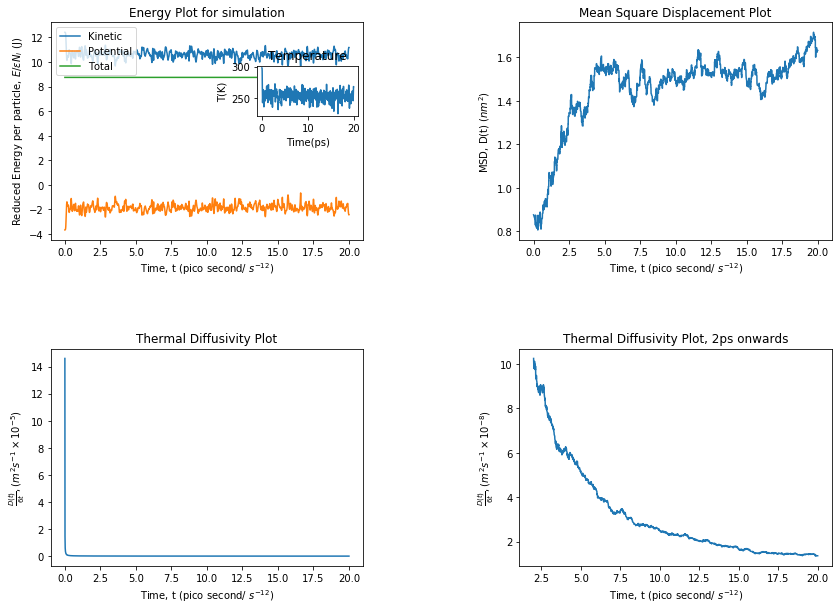
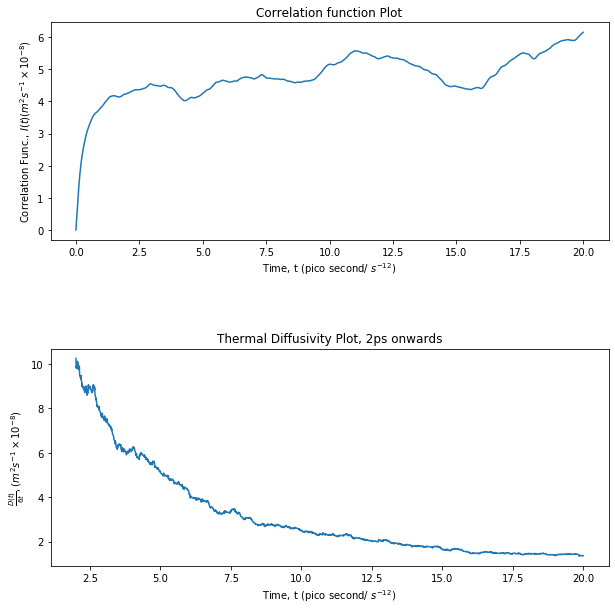